In [1]:
# import packages
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.stats as sms
import statsmodels.stats.api as smss
from scipy import stats
import numpy as np
import warnings
warnings.filterwarnings('ignore')

C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# import data
df = pd.read_csv('BGVSpringboardData.csv')

In [3]:
#Set TourID to index
df= df.set_index('TourID_dimension')

# create dictionary to change binary categorical output variable to an integer
dic = {'Sale':1,'No Sale':0}

dic1 = {'Yes':1,'No':0}

dic2 = {'In State':1,'Out of State':0}

dic3 = {'Owner':1,'1st Gen':0}

dic4 = {'Couple':1,'Single':0}

dic5 = {'Weekday':0, 'Weekend':1}


# convert binary categorical output variable to integer values ) and 1
df['ResultOfTour']=df['ResultOfTour'].replace(dic)

df['Homeowner']=df['Homeowner'].replace(dic1)

df['InState']=df['InState'].replace(dic2)

df['FirstGenVsOwner']=df['FirstGenVsOwner'].replace(dic3)

df['relationStatus']=df['relationStatus'].replace(dic4)

df['WeekdayOrWeekend']=df['WeekdayOrWeekend'].replace(dic5)

df = df[df['ResultOfTour']==1]

print(df.info())




<class 'pandas.core.frame.DataFrame'>
Int64Index: 2828 entries, 256888 to 384775
Data columns (total 15 columns):
?TourContractGeneration       2828 non-null int64
?TourGeneration               2828 non-null int64
Age                           2828 non-null int64
AgentLine                     2828 non-null object
BookingWindow                 2828 non-null object
FirstGenVsOwner               2828 non-null int64
HHIncomeRanges                2828 non-null object
Homeowner                     2828 non-null int64
InState                       2828 non-null int64
Programs (Budget)             2828 non-null object
relationStatus                2828 non-null int64
ResultOfTour                  2828 non-null int64
TourSeason                    2828 non-null object
WeekdayOrWeekend              2828 non-null int64
NetVolumePlusNonGoodVolume    2828 non-null float64
dtypes: float64(1), int64(9), object(5)
memory usage: 353.5+ KB
None


In [4]:
# remove outliers from predicting model:
df['NetVolumePlusNonGoodVolume'] = (df['NetVolumePlusNonGoodVolume']+1).apply(np.sqrt)
print(len(df))
pU, pL = np.percentile(df['NetVolumePlusNonGoodVolume'], [99.85 ,0.15])
df = df.loc[df['NetVolumePlusNonGoodVolume'] <= (pU)]
df = df.loc[df['NetVolumePlusNonGoodVolume'] >= (pL)]
df['NetVolumePlusNonGoodVolume'] = np.power(df['NetVolumePlusNonGoodVolume'],2)
print(len(df))

2828
2818


In [5]:
print(len(df))
pU, pL = np.percentile(df['Age'], [99.85 ,0.15])
df = df.loc[df['Age'] <= (pU)]
df = df.loc[df['Age'] >= (pL)]
print(len(df))

2818
2810


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

dfX = df.drop(['ResultOfTour', 'NetVolumePlusNonGoodVolume'], axis = 1)

dfX = pd.get_dummies(dfX, prefix=['AgentLine', 'BookingWindow', 'HHIncomeRanges', 'Programs (Budget)','TourSeason'])
                                  
scaler1 = StandardScaler()
scaler1.fit(dfX[['Age']])
dfX['Age'] = scaler1.transform(dfX[['Age']])

scaler2 = StandardScaler()
scaler2.fit(dfX[['?TourContractGeneration']])
dfX['?TourContractGeneration'] = scaler2.transform(dfX[['?TourContractGeneration']])

scaler3 = StandardScaler()
scaler3.fit(dfX[['?TourGeneration']])
dfX['?TourGeneration'] = scaler3.transform(dfX[['?TourGeneration']])

scaler4 = StandardScaler()
scaler4.fit(df[['NetVolumePlusNonGoodVolume']])
df['NetVolumePlusNonGoodVolume'] = scaler4.transform(df[['NetVolumePlusNonGoodVolume']])


X_train, X_test, y_train, y_test = train_test_split(dfX, df['NetVolumePlusNonGoodVolume'], test_size=0.2,random_state = 42)




dfX1 = X_train
dfY1 = y_train
 



print(dfX1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2248 entries, 376600 to 354088
Data columns (total 41 columns):
?TourContractGeneration                        2248 non-null float64
?TourGeneration                                2248 non-null float64
Age                                            2248 non-null float64
FirstGenVsOwner                                2248 non-null int64
Homeowner                                      2248 non-null int64
InState                                        2248 non-null int64
relationStatus                                 2248 non-null int64
WeekdayOrWeekend                               2248 non-null int64
AgentLine_Breck                                2248 non-null uint8
AgentLine_Colorado                             2248 non-null uint8
AgentLine_Other Line                           2248 non-null uint8
BookingWindow_Inside 2 Days                    2248 non-null uint8
BookingWindow_Inside 90 days                   2248 non-null uint8
BookingWi

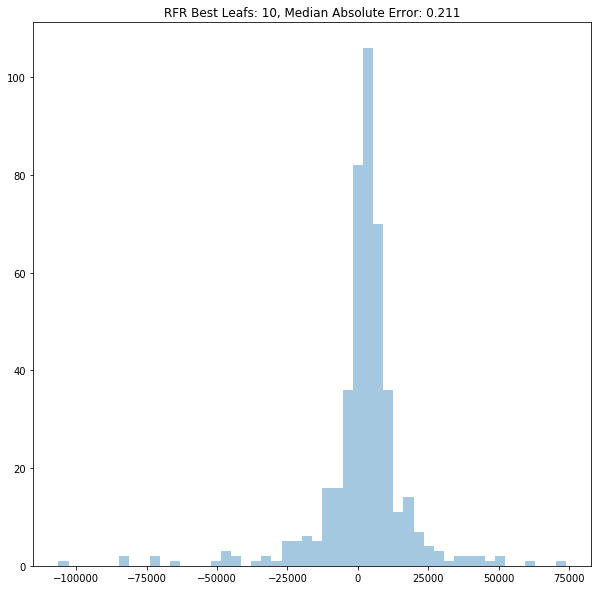

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)

bestLRFR =0
bestR2RFR=1
bestFIRFR = []
bestDiffRFR = []
i=0
#make cross validation of K values and kfold
Ls = [1,5,10,20,40]
np.random.shuffle(Ls)
kf = KFold(5, random_state= 0)


for train, test in kf.split(dfX1,dfY1):
    rfr = RandomForestRegressor(n_estimators=1000,min_samples_leaf=Ls[i])
    rfr.fit(dfX1.iloc[train.tolist()],dfY1.iloc[train.tolist()])
    preds = rfr.predict(dfX1.iloc[test.tolist()])
    score = median_absolute_error(dfY1.iloc[test.tolist()], preds)
    if score < bestR2RFR:
        bestR2RFR = score
        bestLRFR = Ls[i]
        bestFIRFR = rfr.feature_importances_
        bestDiffRFR = scaler4.inverse_transform(preds ) - scaler4.inverse_transform(dfY1.iloc[test.tolist()] )
    i += 1 
    
    
  
sns.distplot(bestDiffRFR, kde=False)
plt.title('RFR Best Leafs: ' + str(bestLRFR)+ ', Median Absolute Error: '+ str(round(bestR2RFR,3)))
plt.show()



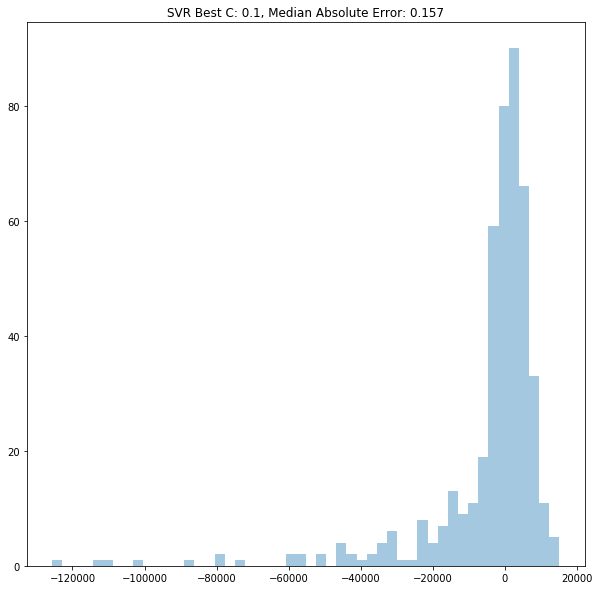

In [8]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold


#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)

bestCSVR = 0
bestR2SVR = 1
bestDiffSVR = []

i=0
#make cross validation of K values and kfold
Cs = [0.01, 0.1, 1,10,100]
np.random.shuffle(Cs)
kf = KFold(5, random_state= 42)


for train, test in kf.split(dfX1,dfY1):
    rfr = SVR(C=Cs[i])
    rfr.fit(dfX1.iloc[train.tolist()],dfY1.iloc[train.tolist()])
    preds = rfr.predict(dfX1.iloc[test.tolist()])
    score = median_absolute_error(dfY1.iloc[test.tolist()], preds)
    if score < bestR2SVR:
        bestR2SVR = score
        bestCSVR = Cs[i]
        bestDiffSVR = scaler4.inverse_transform(preds ) - scaler4.inverse_transform(dfY1.iloc[test.tolist()] )
    i += 1 
    
    
sns.distplot(bestDiffSVR, kde=False)
plt.title('SVR Best C: ' + str(bestCSVR)+ ', Median Absolute Error: '+ str(round(bestR2SVR,3)))
plt.show()



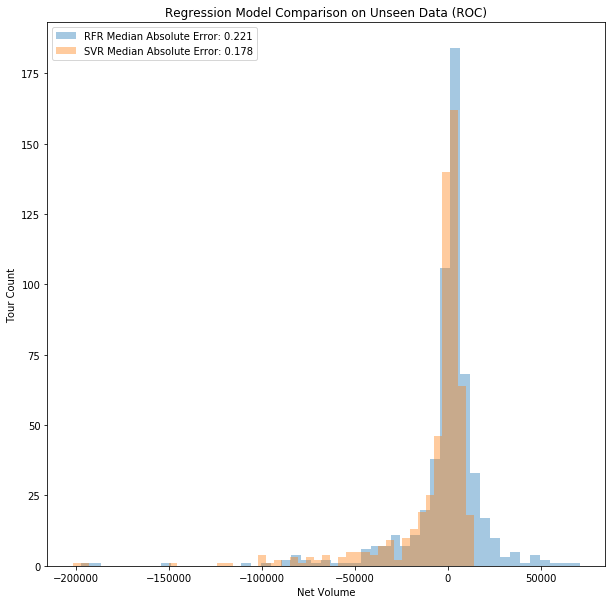

In [9]:
#random forest best model 
rf = RandomForestRegressor(n_estimators=1000,min_samples_leaf =bestLRFR,random_state=42)
rf.fit(dfX1,dfY1)
preds = rf.predict(X_test)
rfrScore = median_absolute_error(y_test, preds)
diffRFR = scaler4.inverse_transform(preds ) - scaler4.inverse_transform(y_test )
sns.distplot(diffRFR, kde=False, label='RFR Median Absolute Error: '+ str(round(rfrScore,3)))


#support vector best model
svr = SVR(C=bestCSVR)
svr.fit(dfX1,dfY1)
preds = svr.predict(X_test)
svrScore = median_absolute_error(y_test, preds)
diffSVR = scaler4.inverse_transform(preds ) - scaler4.inverse_transform(y_test )
sns.distplot(diffSVR, kde=False, label='SVR Median Absolute Error: '+ str(round(svrScore,3)))


plt.xlabel('Net Volume')
plt.ylabel('Tour Count')
plt.legend()
plt.title('Regression Model Comparison on Unseen Data (ROC)')
plt.show()

In [10]:
print('Random Forest Regression Feature Importances: ')
print()
for x,y in sorted(zip(list(rf.feature_importances_), X_test.columns.tolist()), reverse =True):
    print(str(round(x,4)),'\t: ',str(y) )

Random Forest Regression Feature Importances: 

0.214 	:  HHIncomeRanges_350k to 500k
0.1765 	:  InState
0.1366 	:  HHIncomeRanges_Over 500k
0.0928 	:  ?TourContractGeneration
0.0879 	:  Age
0.0609 	:  ?TourGeneration
0.0572 	:  BookingWindow_Inside 2 Days
0.052 	:  HHIncomeRanges_200k to 349k
0.0176 	:  TourSeason_Spring
0.0168 	:  Programs (Budget)_(14) Summit County OPC
0.0108 	:  TourSeason_Winter
0.0105 	:  HHIncomeRanges_150k to 199k
0.0095 	:  WeekdayOrWeekend
0.0088 	:  FirstGenVsOwner
0.0079 	:  Programs (Budget)_(09) GL7 Inhouse
0.0047 	:  BookingWindow_Inside Month
0.0041 	:  Programs (Budget)_(06) GC8 Inhouse
0.0036 	:  HHIncomeRanges_90k to 149k
0.0036 	:  TourSeason_Summer
0.0032 	:  BookingWindow_Inside Week
0.003 	:  Programs (Budget)_(21) GTL In House
0.0027 	:  AgentLine_Colorado
0.0022 	:  BookingWindow_Over a Year
0.0022 	:  TourSeason_Fall
0.0021 	:  HHIncomeRanges_70k to 89k
0.0016 	:  relationStatus
0.0015 	:  BookingWindow_Inside 90 days
0.0013 	:  AgentLine_Bre